通过对每层注意力权重的均值、方差等统计指标计算，来评估模型在各层对图像不同区域的关注程度。

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

In [ ]:
# 定义图像分块和嵌入模块
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embedding_size=768):
        """
        Args:
            img_size (int): 输入图像的大小（假设为正方形图像）
            patch_size (int): 每个图像块的大小
            in_channels (int): 输入图像的通道数
            embedding_size (int): 每个图像块嵌入的维度
        """
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size # 224
        self.patch_size = patch_size # 16
        self.num_patches = (img_size // patch_size) ** 2 # 196 = (224/16=14) * (224/16=14)

        self.projection = nn.Conv2d(in_channels, embedding_size, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embedding_size)) # 分类标记，需要计算梯度，可学习的参数 (1, 1, embedding_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.num_patches + 1, embedding_size))

    def forward(self, x):
        """
        Args:
            x (Tensor): 输入图像张量，形状为 (B, C, H, W)
        Returns:
            Tensor: 输出嵌入张量，形状为 (B, num_patches + 1, embedding_size)
        """
        projection_out = self.projection(x)  # (B, embedding_size, H/patch_size, W/patch_size)
        x = projection_out.flatten(2)  # (B, embedding_size, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embedding_size)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)  # (B, 1, embedding_size)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, num_patches + 1, embedding_size)
        x = x + self.position_embeddings  # 添加位置嵌入
        return x

In [40]:
a = torch.tensor([[[1,2,3],[4,5,6]]])
print("Original tensor shape:", a.shape)
b = a.expand(2, -1, -1)
print("Expanded tensor shape:", b.shape)
b

Original tensor shape: torch.Size([1, 2, 3])
Expanded tensor shape: torch.Size([2, 2, 3])


tensor([[[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]]])

In [32]:
# Transformer编码模块
class TransformerBlock(nn.Module):
    def __init__(self, embedding_size=768, num_heads=12, forward_expansion=4.0, dropout=0.1):
        """
        Args:
            embedding_size (int): 输入嵌入的维度
            num_heads (int): 多头注意力机制中的头数
            forward_expansion (float): 前馈网络中隐藏层的扩展比例
            dropout_rate (float): Dropout的概率
        """
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embedding_size)
        self.attn = nn.MultiheadAttention(embedding_size, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embedding_size)
        self.fead_forward = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size * forward_expansion)),
            nn.GELU(),
            nn.Linear(int(embedding_size * forward_expansion), embedding_size),
            nn.Dropout(dropout)
        )

    def forward(self, value, key, query):
        """
        Args:
            value, key, query: 多头注意力机制的输入
        Returns:
            输出经过Transformer编码块处理后的结果和注意力权重
        """
        attn_output, weights = self.attn(query, key, value, need_weights=True)
        norm1_output = self.norm1(attn_output + query)
        forward_output = self.fead_forward(norm1_output)
        norm2_output = self.norm2(forward_output + norm1_output)
        return norm2_output, weights

In [33]:
# Vision Transformer模型定义，带注意力权重返回
class VisionTransformerWithWeights(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embedding_size=768,
                 num_heads=12, forward_expansion=4.0, num_layers=12, num_classes=1000, dropout=0.1):
        """
        Args:
            img_size (int): 输入图像的大小
            patch_size (int): 每个图像块的大小
            in_channels (int): 输入图像的通道数
            embedding_size (int): 每个图像块嵌入的维度
            num_heads (int): 多头注意力机制中的头数
            forward_expansion (float): 前馈网络中隐藏层的扩展比例
            num_layers (int): Transformer编码块的数量
            num_classes (int): 分类任务中的类别数
            dropout_rate (float): Dropout的概率
        """
        super(VisionTransformerWithWeights, self).__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embedding_size)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(embedding_size, num_heads, forward_expansion, dropout) for _ in range(num_layers)]
        )
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embedding_size),
            nn.Linear(embedding_size, num_classes)
        )

    def forward(self, x):
        """
        Args:
            x (Tensor): 输入图像张量，形状为 (B, C, H, W)
        Returns:
            Tensor: 分类结果，形状为 (B, num_classes)
            List[Tensor]: 每个Transformer块的注意力权重
        """
        x = patches = self.patch_embedding(x)
        print("Patch embeddings shape:", patches.shape)
        attention_weights = []
        for block in self.transformer_blocks:
            x, weights = block(x, x, x)
            attention_weights.append(weights)
        x = self.to_cls_token(x[:, 0])
        logits = self.mlp_head(x)
        return logits, attention_weights

In [34]:
# 加载并预处理图像
image_path = './yumi.png'
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_image = transform(image).unsqueeze(0)  # 添加批次维度
print("Input image shape:", input_image.shape)

Input image shape: torch.Size([1, 3, 224, 224])


In [35]:
# 初始化ViT模型并进行前向传播
vit_model = VisionTransformerWithWeights()
logits, attention_weights = vit_model(input_image)
print("Logits shape:", logits.shape)

cls_tokens shape: torch.Size([1, 1, 768])
Patch embeddings shape: torch.Size([1, 197, 768])
Logits shape: torch.Size([1, 1000])


In [13]:
# 严格量化分析函数
def quantify_attention(attention_weights):
    """
    对注意力权重进行量化分析，计算每个注意力头的平均注意力分布。
    
    Args:
        attention_weights (list of tensors): 每个Transformer块的注意力权重列表。
        
    Returns:
        list of numpy arrays: 每个Transformer块中每个注意力头的平均注意力分布。
    """
    layer_analyzis = []
    for layer_index, weights in enumerate(attention_weights):
        # weights shape: (batch_size, num_heads, seq_len, seq_len)
        print(f"Layer {layer_index + 1} Attention Weights Shape:", weights.shape)
        mean_weights = weights.mean(dim=1).squeeze().detach().cpu().numpy()  # 计算平均注意力权重
        var_weights = weights.var(dim=1).squeeze().detach().cpu().numpy()  # 计算方差注意力权重
        layer_summary = {
            'layer_index': layer_index + 1,
            'mean_attention': mean_weights,
            'var_attention': var_weights
        }
        layer_analyzis.append(layer_summary)
        # 输出每层的平均注意力分布
        print(f"Layer {layer_index + 1} Mean Attention Weights:\n", mean_weights)
    return layer_analyzis

Layer 1 Attention Weights Shape: torch.Size([197, 1, 1])
Layer 1 Mean Attention Weights:
 [0.9259259 1.0185184 1.0185184 1.0185184 1.0185184 0.8333333 1.111111
 1.111111  1.111111  1.0185184 0.8333333 1.0185184 0.8333333 1.0185184
 0.8333333 0.9259259 0.9259259 1.0185184 0.9259259 1.111111  1.0185184
 1.0185184 1.0185184 1.111111  0.9259259 1.111111  0.8333333 0.8333333
 1.111111  1.0185184 0.9259259 1.0185184 0.9259259 1.111111  0.8333333
 0.9259259 1.0185184 0.9259259 0.7407408 1.0185184 1.0185184 1.111111
 1.0185184 0.9259259 0.9259259 1.0185184 1.111111  1.0185184 1.111111
 1.111111  1.0185184 0.9259259 1.0185184 1.0185184 0.9259259 1.0185184
 0.7407408 1.111111  1.0185184 1.0185184 1.111111  1.111111  1.0185184
 1.0185184 1.0185184 1.0185184 0.8333333 0.9259259 1.0185184 0.9259259
 1.0185184 1.111111  1.0185184 1.0185184 0.9259259 1.111111  0.9259259
 1.111111  1.111111  0.8333333 1.0185184 1.0185184 1.0185184 1.111111
 1.111111  1.0185184 1.0185184 1.0185184 0.8333333 1.111111  1

/tmp/ipykernel_2900874/176191235.py:17: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  var_weights = weights.var(dim=1).squeeze().detach().cpu().numpy()  # 计算方差注意力权重


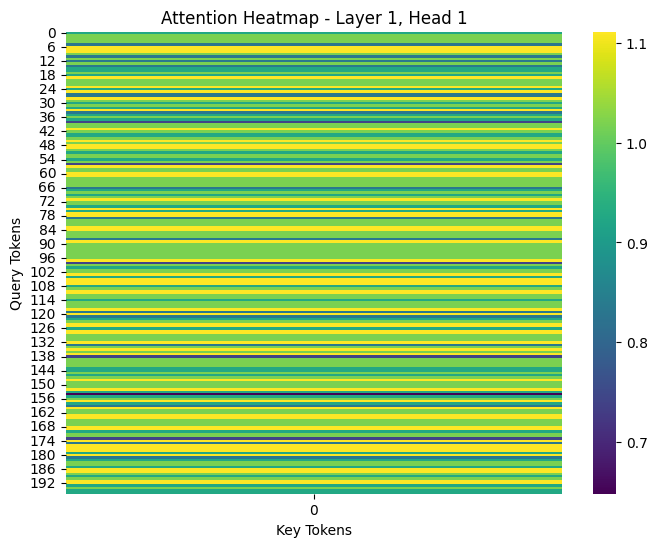

In [14]:
# 绘制注意力热图函数
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_heatmap(attention_matrix, layer_index, head_index):
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_matrix, cmap='viridis')
    plt.title(f'Attention Heatmap - Layer {layer_index + 1}, Head {head_index + 1}')
    plt.xlabel('Key Tokens')
    plt.ylabel('Query Tokens')
    plt.show()
# 进行量化分析
analysis_results = quantify_attention(attention_weights)
# 绘制第一层第一个头的注意力热图作为示例
first_layer_mean_attention = analysis_results[0]['mean_attention'][:, np.newaxis]
print("First Layer Mean Attention Weights Shape:\n", first_layer_mean_attention.shape)
plot_attention_heatmap(first_layer_mean_attention, layer_index=0, head_index=0)